# Data dictionary

# [Link to dataset](https://www.kaggle.com/datasets/etiennekaiser/gemini-pro-llm-daigt-dataset)

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-za14{border-color:inherit;text-align:left;vertical-align:bottom}
.tg .tg-7zrl{text-align:left;vertical-align:bottom}
</style>
<table class="tg"><thead>
  <tr>
    <th class="tg-za14">Variable Name</th>
    <th class="tg-7zrl">Description</th>
    <th class="tg-7zrl">Data Type</th>
  </tr></thead>
<tbody>
  <tr>
    <td class="tg-7zrl">text</td>
    <td class="tg-7zrl">The essay created by each prompt</td>
    <td class="tg-7zrl">Text/String</td>
  </tr>
  <tr>
    <td class="tg-7zrl">label</td>
    <td class="tg-7zrl">Indicating whether the essay originated from a student (0) or was generated by a Language Model (LLM) (1)</td>
    <td class="tg-7zrl">Numeric/Binary</td>
  </tr>
  <tr>
    <td class="tg-7zrl">prompt_name</td>
    <td class="tg-7zrl">Represents which of the seven prompts was used during generation of an essay</td>
    <td class="tg-7zrl">Categorical/String</td>
  </tr>
  <tr>
    <td class="tg-7zrl">source</td>
    <td class="tg-7zrl">The used model during text generation (gemini_pro)</td>
    <td class="tg-7zrl">Categorical/String</td>
  </tr>
  <tr>
    <td class="tg-7zrl">RDizzl3_seven</td>
    <td class="tg-7zrl">Boolean flag</td>
    <td class="tg-7zrl">Boolean</td>
  </tr>
</tbody></table>

# Load dataset

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gemini-pro-llm-daigt-dataset/train_essays_v1.csv


In [2]:
# Install dependencies (only if not already installed)
!pip install rouge_score
!pip install wordcloud # Added as it was imported later

import re
import numpy as np
import pandas as pd
import pickle # For saving/loading tokenizer
import string # Import string for punctuation
from itertools import combinations

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
# Consolidated Keras layers
from tensorflow.keras.layers import Input, Embedding, Dropout, Dense, LayerNormalization, MultiHeadAttention, Layer
# Combined optimizers (Adam and AdamW were both present in different blocks)
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses import SparseCategoricalCrossentropy
# Combined callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split

import nltk # Import NLTK for sentence tokenization
from nltk.tokenize import sent_tokenize # Specific import for sentence tokenization

from rouge_score import rouge_scorer
from wordcloud import WordCloud, STOPWORDS # Import WordCloud and STOPWORDS

# Plotting library
import matplotlib.pyplot as plt


# Download NLTK 'punkt' tokenizer data if not already present
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    print("NLTK 'punkt' tokenizer not found. Downloading...")
    nltk.download('punkt')
    print("NLTK 'punkt' tokenizer downloaded.")

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=44abbf3f97cd39ba948a18d7df9a915b42f32112386f2ef1885b75eddeb10587
  Stored in directory: /root/.cache/pip/wheels/1e/19/43/8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score


2025-07-28 12:04:15.158239: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753704255.398480      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753704255.470990      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load dataset

In [3]:
df = pd.read_csv('/kaggle/input/gemini-pro-llm-daigt-dataset/train_essays_v1.csv')
df = df["text"]
df = df.to_frame()
df.head()

,text
0,The Electoral College is a complex system that...
1,"The exploration of Venus, Earth's closest plan..."
2,## Does the Electoral College Work?\n\nThe Ele...
3,"In the vast realm of literature, there exists ..."
4,"In the realm of modern transportation, the adv..."


In [4]:
# Take a 50% sample of the DataFrame
# frac=0.5 means 50% of the rows
# random_state for reproducibility, so you get the same sample every time you run it
df = df.sample(frac=0.02, random_state=42)

print(f"Sampled DataFrame shape (50%): {df.shape}")

# Display the head of the sampled DataFrame
print("\nHead of the 50% sampled DataFrame:")
print(df.head())

Sampled DataFrame shape (50%): (70, 1)

Head of the 50% sampled DataFrame:
                                                   text
1650  The Electoral College, a system rooted in the ...
2456  In the vast expanse of the cosmos, the human g...
2232  The Facial Action Coding System (FACS), develo...
1945  The novel "A Cowboy Who Rode the Waves" by Wil...
309   ## Unveiling the Benefits of Car-Free Cities: ...


# Split data into train and test

In [5]:
# Split the data into training and testing sets
train, test = train_test_split(df, test_size=0.2, random_state=42) 

# Print the shapes of the resulting sets
print("train shape:", train.shape)
print("test shape:", test.shape)

train shape: (56, 1)
test shape: (14, 1)


# Data Visualization

In [6]:
train.shape

(56, 1)

In [7]:
train.isnull().sum()

text    0
dtype: int64

In [8]:
test.isnull().sum()

text    0
dtype: int64

In [9]:
# Check if 'text' column exists and print 5 sentences
if 'text' in train.columns:
    print("First 5 sentences from the 'text' column:")
    for i, essay_text in enumerate(train['text'].head(5)):
        print(f"--- Essay {i+1} ---")
        print(essay_text)
        print("\n") # Add an extra newline for better separation
else:
    print("Error: 'text' column not found in the DataFrame. Cannot display sentences.")

First 5 sentences from the 'text' column:
--- Essay 1 ---
In the realm of extraordinary feats, the tale of a cowboy who rode the waves stands out as a testament to the boundless nature of human spirit. This audacious adventurer, with his unwavering determination and unconventional approach, defied the societal norms and carved a new path, etching his name in the annals of history.

The cowboy, raised in the vast open ranges, was accustomed to the rhythm of the land, the rumble of hooves beneath him, and the boundless freedom of the prairie. However, an insatiable curiosity burned within him, a yearning to explore uncharted territories beyond the familiar horizon.

When whispers of the ocean's allure reached his ears, a flame was ignited in his heart. Intrigued by the vast expanse of water, the cowboy resolved to conquer this new frontier. Undeterred by the lack of conventional seafaring experience, he embarked on a journey that would redefine his destiny.

With unwavering resolve, he c

## Check number of words in longest sentence

In [10]:
# Initialize variables to store the longest sentence length and count
max_sentence_length = 0
count_longest_sentences = 0
longest_sentences_examples = [] # Optional: to store examples of longest sentences

# Iterate through each essay in the 'text' column
# Using .astype(str) to handle potential non-string entries (e.g., NaN)
for essay_text in train['text'].astype(str):
    # Split the essay into sentences using common delimiters (., !, ?)
    # The regex `(?<=[.!?])\s+` splits after a punctuation mark followed by one or more spaces.
    # This helps keep the punctuation with the sentence, but we'll strip it later.
    sentences = re.split(r'(?<=[.!?])\s+', essay_text)

    for sentence in sentences:
        # Clean up the sentence: remove leading/trailing whitespace and punctuation
        cleaned_sentence = re.sub(r'[.!?]$', '', sentence).strip()

        if cleaned_sentence: # Ensure the sentence is not empty after cleaning
            # Count words by splitting by whitespace
            word_count = len(cleaned_sentence.split())

            if word_count > max_sentence_length:
                max_sentence_length = word_count
                count_longest_sentences = 1 # Reset count for a new longest sentence
                longest_sentences_examples = [cleaned_sentence] # Start new list of examples
            elif word_count == max_sentence_length and max_sentence_length > 0:
                count_longest_sentences += 1 # Increment count if length matches current max
                longest_sentences_examples.append(cleaned_sentence) # Add to examples

print(f"\n--- Analysis Results ---")
print(f"The longest sentence length found (in words) is: {max_sentence_length}")
print(f"The number of sentences with this maximum length is: {count_longest_sentences}")

# Optional: Print examples of the longest sentences
if longest_sentences_examples:
    print("\n--- Examples of Longest Sentences ---")
    # Print up to 5 examples to avoid overwhelming output
    for i, example in enumerate(longest_sentences_examples[:5]):
        print(f"{i+1}. \"{example}\"")
    if len(longest_sentences_examples) > 5:
        print(f"... and {len(longest_longest_sentences_examples) - 5} more.")


--- Analysis Results ---
The longest sentence length found (in words) is: 54
The number of sentences with this maximum length is: 1

--- Examples of Longest Sentences ---
1. "Through the lens of historical fiction, this essay will delve into the significance of the novel and argue that it serves as a powerful testament to the indomitable spirit of the American frontier, the enduring legacy of the Old West, and the universal themes of courage, resilience, and adaptation in the face of adversity"


## Check unapproite symbol in text

In [11]:
# Define a regex pattern to find special characters and newline/tab characters
# r'[\n\r\t!@#$%^&*()-_+=[]{}\|;:\'",.<>/?`~]'
# Explanation of pattern:
# [\n\r\t]: Matches newline, carriage return, or tab characters.
# !@#$%^&*()-_+=[]{}\|;:\'",.<>/?`~: Matches a wide range of common symbols.
# The backslashes before some symbols (like \, [, ], {, }, |, :, ', ", <, >, ?, ., +, *) are for escaping them
# because they have special meaning in regex.
special_chars_pattern = re.compile(r'[\n\r\t!@#$%^&*()-_+=[]{}\|;:\'",.<>/?`~]')

# List to store essays with special characters
essays_with_special_chars = []

# Iterate through the 'text' column
for index, essay_text in train['text'].astype(str).items(): # .astype(str) to handle potential non-string entries
    # Find all matches of the pattern in the current essay
    matches = special_chars_pattern.findall(essay_text)

    if matches:
        # If matches are found, add the essay to our list
        essays_with_special_chars.append({
            'index': index,
            'text': essay_text,
            'found_chars': sorted(list(set(matches))) # Get unique sorted characters found
        })

# Display the results
if essays_with_special_chars:
    print(f"Found {len(essays_with_special_chars)} essays containing special characters or newlines/tabs.\n")
    print("--- Examples of Essays with Special Characters (first 5) ---")
    for i, item in enumerate(essays_with_special_chars[:5]): # Display up to 5 examples
        print(f"\nEssay Index: {item['index']}")
        print(f"Special characters found: {', '.join(item['found_chars'])}")
        # Print a truncated version of the essay for readability
        print("Text snippet:", item['text'][:300] + "..." if len(item['text']) > 300 else item['text'])
        print("-" * 50)
    if len(essays_with_special_chars) > 5:
        print(f"\n...and {len(essays_with_special_chars) - 5} more essays with special characters.")
else:
    print("No essays found containing the specified special characters or newlines/tabs.")

No essays found containing the specified special characters or newlines/tabs.


## Find number of vocabulary size

In [12]:
# --- Tokenization and Vocabulary Size Calculation (before cleaning) ---
# Initialize the Tokenizer.
# By default, Tokenizer converts to lowercase and removes punctuation.
# To get the vocabulary *before* cleaning (i.e., including punctuation and case differences),
# we need to set `lower=False` and `filters=''` (empty string for filters).
tokenizer_raw = Tokenizer(lower=False, filters='', oov_token="<unk>")

# Fit the tokenizer on the ORIGINAL 'text' column directly
tokenizer_raw.fit_on_texts(train['text'].astype(str)) # .astype(str) to handle potential non-string entries

# The vocabulary size is the number of unique words/tokens found (len(tokenizer_raw.word_index))
# plus 1 for the implicit padding token (index 0) used by Keras's pad_sequences.
vocabulary_size_raw = len(tokenizer_raw.word_index) + 1

print(f"The vocabulary size of the `train['text']` column before cleaning is: {vocabulary_size_raw}")
print(f"This includes {len(tokenizer_raw.word_index)} unique tokens (considering case and punctuation), plus 1 for the padding token (index 0).")
print(f"The index assigned to the Out-Of-Vocabulary (OOV) token '<unk>' is: {tokenizer_raw.word_index.get('<unk>', 'Not Found')}")

The vocabulary size of the `train['text']` column before cleaning is: 5064
This includes 5063 unique tokens (considering case and punctuation), plus 1 for the padding token (index 0).
The index assigned to the Out-Of-Vocabulary (OOV) token '<unk>' is: 1


## Visualize most frequence words in corpus

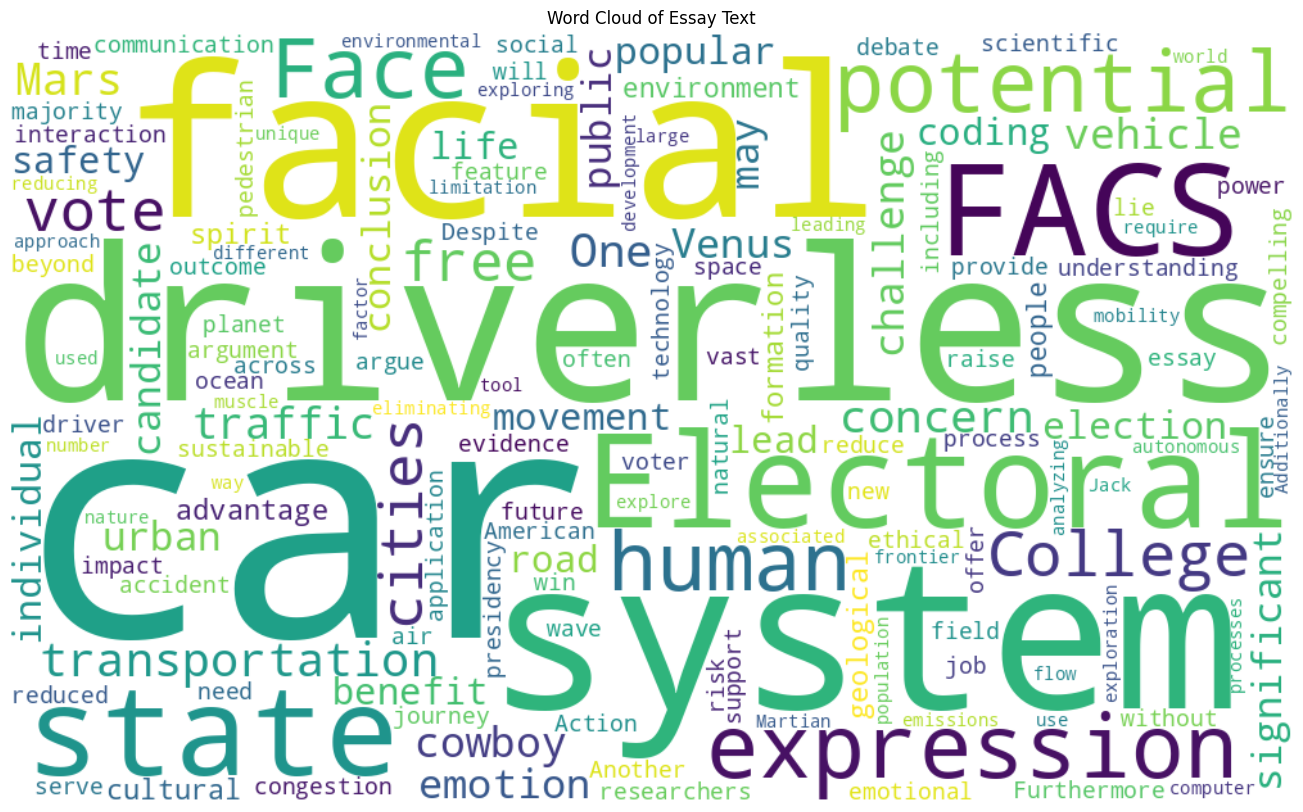

In [13]:
# Concatenate all text from the 'text' column into a single string
# Convert all entries to string type to handle potential non-string data (e.g., NaN)
all_text = ' '.join(train['text'].astype(str).tolist())

# Define stopwords (common words to exclude from the word cloud)
# You can add more domain-specific stopwords if needed
stopwords = set(STOPWORDS)
stopwords.update(["the", "a", "an", "is", "it", "this", "that", "and", "of", "to", "in", "for", "on", "with", "as", "by"]) # Add common English words

# Create a WordCloud object
# You can customize parameters like width, height, background_color, max_words, etc.
wordcloud = WordCloud(
    width=1000, # Width of the word cloud image
    height=600, # Height of the word cloud image
    background_color='white', # Background color
    stopwords=stopwords, # Words to exclude
    min_font_size=10, # Minimum font size for words
    max_words=150, # Maximum number of words to display
    collocations=False # Set to False to prevent plotting words that frequently appear together
).generate(all_text)

# Display the generated image:
plt.figure(figsize=(20, 10)) # Set figure size for better display
plt.imshow(wordcloud, interpolation='bilinear') # Display the word cloud
plt.axis("off") # Turn off axis labels
plt.title("Word Cloud of Essay Text") # Add a title
plt.show()

# Data Preprocessing

## Text Cleaning

In [14]:
# --- Dataset Cleaning & Sentence Tokenization ---
# This clean_text function is adapted from your provided pipeline (using string.punctuation)
def clean_text_from_provided_pipeline(txt):
    txt = str(txt) # Ensure text is string
    # Remove punctuation and convert to lowercase
    txt = "".join(v for v in txt if v not in string.punctuation).lower()
    # Encode to utf8 and decode to ascii, ignoring errors (removes non-ascii chars)
    txt = txt.encode("utf8").decode("ascii",'ignore')
    # Additional cleaning steps from your original code
    txt = re.sub(r'##+', ' ', txt) # Remove '##' markers
    txt = re.sub(r'\[.*?\]', '', txt) # Remove text within square brackets
    txt = re.sub(r'https?://\S+|www.\S+', '', txt) # Remove URLs
    txt = re.sub(r'<.*?>+', '', txt) # Remove HTML tags
    txt = re.sub(r'\n', ' ', txt) # Replace newlines with spaces
    txt = re.sub(r'\w*\d\w*', '', txt) # Remove words containing digits
    txt = re.sub(r'\s+', ' ', txt).strip() # Replace multiple spaces with single and strip
    return txt

def tokenize_paragraph_to_sentences_and_clean(paragraph_text):
    """
    Tokenizes a paragraph into sentences and cleans each sentence.
    Returns a list of cleaned sentences.
    """
    sentences = sent_tokenize(paragraph_text)
    # Filter out empty strings after cleaning
    cleaned_sentences = [clean_text_from_provided_pipeline(s) for s in sentences if clean_text_from_provided_pipeline(s)]
    return cleaned_sentences

print("Cleaning and sentence tokenizing training text data...")
# Apply sentence tokenization and cleaning to each paragraph, then flatten the list
all_cleaned_sentences_train = []
for paragraph in train['text']:
    all_cleaned_sentences_train.extend(tokenize_paragraph_to_sentences_and_clean(paragraph))

Cleaning and sentence tokenizing training text data...


In [15]:
print("Cleaning and sentence tokenizing test text data...")
all_cleaned_sentences_test = []
for paragraph in test['text']:
    all_cleaned_sentences_test.extend(tokenize_paragraph_to_sentences_and_clean(paragraph))

Cleaning and sentence tokenizing test text data...


In [16]:
print(f"\nTotal cleaned sentences in training set: {len(all_cleaned_sentences_train)}")
print(f"Total cleaned sentences in test set: {len(all_cleaned_sentences_test)}")
print("\nSample cleaned sentences from training data (first 3):\n")
for i, sentence_sample in enumerate(all_cleaned_sentences_train[:3]):
    print(f"--- Cleaned Train Sentence {i+1} ---")
    print(sentence_sample[:200], "...")
    print("-" * 50)


Total cleaned sentences in training set: 1333
Total cleaned sentences in test set: 361

Sample cleaned sentences from training data (first 3):

--- Cleaned Train Sentence 1 ---
in the realm of extraordinary feats the tale of a cowboy who rode the waves stands out as a testament to the boundless nature of human spirit ...
--------------------------------------------------
--- Cleaned Train Sentence 2 ---
this audacious adventurer with his unwavering determination and unconventional approach defied the societal norms and carved a new path etching his name in the annals of history ...
--------------------------------------------------
--- Cleaned Train Sentence 3 ---
the cowboy raised in the vast open ranges was accustomed to the rhythm of the land the rumble of hooves beneath him and the boundless freedom of the prairie ...
--------------------------------------------------


## Tokenization and Vocabulary Building

In [17]:
# --- Simulate Dummy Data ---
# In a real scenario, example_train and example_test would be pandas DataFrames
# with a 'cleaned_text' column.
example_train_data = {
    'cleaned_text': [
        "this is a great movie",
        "the movie was fantastic",
        "i love this film",
        "what a terrible movie",
        "this film is bad"
    ]
}
example_test_data = {
    'cleaned_text': [
        "a fantastic film it was",
        "i hate this bad movie",
        "great acting"
    ]
}

example_train = pd.DataFrame(example_train_data)
example_test = pd.DataFrame(example_test_data)

print("--- Original Training Texts ---")
for example_text in example_train['cleaned_text']:
    print(f"- {example_text}")
print("\n--- Original Test Texts ---")
for example_text in example_test['cleaned_text']:
    print(f"- {example_text}")

# --- Tokenization and Vocabulary Building ---
# Define constants for vocabulary size and special tokens
example_VOCAB_SIZE = 10  # Adjusted for a small example to see OOV more easily
example_OOV_TOKEN = "<OOV>"
example_SOS_TOKEN = "<SOS>"
example_EOS_TOKEN = "<EOS>"

# Prepend example_SOS_TOKEN and append example_EOS_TOKEN to each text
example_texts_for_tokenization_train = [f"{example_SOS_TOKEN} {example_text} {example_EOS_TOKEN}" for example_text in example_train['cleaned_text']]
example_texts_for_tokenization_test = [f"{example_SOS_TOKEN} {example_text} {example_EOS_TOKEN}" for example_text in example_test['cleaned_text']]

print(f"\n--- Training Texts with Special Tokens ---")
for example_text in example_texts_for_tokenization_train:
    print(f"- {example_text}")

print(f"\n--- Initializing Tokenizer with num_words={example_VOCAB_SIZE} and oov_token='{example_OOV_TOKEN}' ---")
# Initialize the Tokenizer
# filters='' means no punctuation will be removed, and default lower=True will apply
example_tokenizer = Tokenizer(num_words=example_VOCAB_SIZE, oov_token=example_OOV_TOKEN, filters='')

# Fit the example_tokenizer on the training texts to build the vocabulary
# It will only keep the top example_VOCAB_SIZE (10) most frequent words + OOV
example_tokenizer.fit_on_texts(example_texts_for_tokenization_train)

print(f"\n--- Word Counts (before explicit special token addition) ---")
# Display word counts (useful to see what words are most frequent)
# Note: Tokenizer converts to lowercase by default if filters are not explicitly set to prevent it.
example_sorted_word_counts = sorted(example_tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)
for example_word, example_count in example_sorted_word_counts:
    print(f"'{example_word}': {example_count}")

print(f"\n--- Initial Word Index (top {example_VOCAB_SIZE} words + OOV if present) ---")
# Display the initial example_word_index (mapping of words to integer IDs)
# IDs typically start from 1.
# Words are ordered by frequency, so 'the' is 1, 'movie' is 2, etc.
# example_OOV_TOKEN will get an ID if it's implicitly part of the top example_VOCAB_SIZE, or later explicitly added
print(example_tokenizer.word_index)


# Explicitly add special tokens to example_word_index if they are not already there
# This ensures they get an ID even if they aren't among the most frequent words
print(f"\n--- Explicitly adding special tokens if not present ---")
for example_token in [example_SOS_TOKEN, example_EOS_TOKEN, example_OOV_TOKEN]:
    if example_token not in example_tokenizer.word_index:
        example_tokenizer.word_index[example_token] = len(example_tokenizer.word_index) + 1
        print(f"Added '{example_token}' with ID {example_tokenizer.word_index[example_token]}")
    else:
        print(f"'{example_token}' already has ID {example_tokenizer.word_index[example_token]}")


# Calculate the final vocabulary size
# +1 accounts for the 0-index often used for padding
example_VOCAB_SIZE_FINAL = min(len(example_tokenizer.word_index) + 1, example_VOCAB_SIZE + 1)

print(f"\n--- Final Tokenizer Vocabulary Information ---")
print(f"Tokenizer vocabulary size: {example_VOCAB_SIZE_FINAL}")
print(f"Mapping of example_SOS_TOKEN: {example_tokenizer.word_index.get(example_SOS_TOKEN)}")
print(f"Mapping of example_EOS_TOKEN: {example_tokenizer.word_index.get(example_EOS_TOKEN)}")
print(f"Mapping of example_OOV_TOKEN: {example_tokenizer.word_index.get(example_OOV_TOKEN)}")

print(f"\n--- Full Final Word Index ---")
# Display the full example_word_index after adding special tokens
print(example_tokenizer.word_index)

# --- Tokenizing Text into Sequences ---
# Now, let's convert the texts into sequences of integers using the fitted example_tokenizer

# Training data sequences
example_train_sequences = example_tokenizer.texts_to_sequences(example_texts_for_tokenization_train)
print(f"\n--- Sample Training Sequences (first 2) ---")
for example_i, example_seq in enumerate(example_train_sequences[:2]):
    example_original_text = example_texts_for_tokenization_train[example_i]
    print(f"Original: {example_original_text}")
    print(f"Sequence: {example_seq}")
    # Decode back to words for illustration
    example_decoded_words = [list(example_tokenizer.word_index.keys())[list(example_tokenizer.word_index.values()).index(example_idx)] if example_idx != 0 else 'PAD' for example_idx in example_seq]
    print(f"Decoded:  {' '.join(example_decoded_words)}\n")

# Test data sequences
example_test_sequences = example_tokenizer.texts_to_sequences(example_texts_for_tokenization_test)
print(f"\n--- Sample Test Sequences (first 2) ---")
for example_i, example_seq in enumerate(example_test_sequences[:2]):
    example_original_text = example_texts_for_tokenization_test[example_i]
    print(f"Original: {example_original_text}")
    print(f"Sequence: {example_seq}")
    # Decode back to words for illustration
    example_decoded_words = [list(example_tokenizer.word_index.keys())[list(example_tokenizer.word_index.values()).index(example_idx)] if example_idx != 0 else 'PAD' for example_idx in example_seq]
    print(f"Decoded:  {' '.join(example_decoded_words)}\n")

# Example of OOV handling in a new sentence
example_new_sentence = f"{example_SOS_TOKEN} this is a really amazing new film {example_EOS_TOKEN}"
example_new_sequence = example_tokenizer.texts_to_sequences([example_new_sentence])
print(f"\n--- Example with OOV words ---")
print(f"Original new sentence: {example_new_sentence}")
print(f"Sequence for new sentence: {example_new_sequence}")
example_decoded_words_new = [list(example_tokenizer.word_index.keys())[list(example_tokenizer.word_index.values()).index(example_idx)] if example_idx != 0 else 'PAD' for example_idx in example_new_sequence[0]]
print(f"Decoded new sentence:  {' '.join(example_decoded_words_new)}")

--- Original Training Texts ---
- this is a great movie
- the movie was fantastic
- i love this film
- what a terrible movie
- this film is bad

--- Original Test Texts ---
- a fantastic film it was
- i hate this bad movie
- great acting

--- Training Texts with Special Tokens ---
- <SOS> this is a great movie <EOS>
- <SOS> the movie was fantastic <EOS>
- <SOS> i love this film <EOS>
- <SOS> what a terrible movie <EOS>
- <SOS> this film is bad <EOS>

--- Initializing Tokenizer with num_words=10 and oov_token='<OOV>' ---

--- Word Counts (before explicit special token addition) ---
'<sos>': 5
'<eos>': 5
'this': 3
'movie': 3
'is': 2
'a': 2
'film': 2
'great': 1
'the': 1
'was': 1
'fantastic': 1
'i': 1
'love': 1
'what': 1
'terrible': 1
'bad': 1

--- Initial Word Index (top 10 words + OOV if present) ---
{'<OOV>': 1, '<sos>': 2, '<eos>': 3, 'this': 4, 'movie': 5, 'is': 6, 'a': 7, 'film': 8, 'great': 9, 'the': 10, 'was': 11, 'fantastic': 12, 'i': 13, 'love': 14, 'what': 15, 'terrible': 16, 'b

In [18]:
# --- Tokenization and Vocabulary Building ---
VOCAB_SIZE = 5500 # Adjusted for better coverage
OOV_TOKEN = "<OOV>"
SOS_TOKEN = "<SOS>"
EOS_TOKEN = "<EOS>"

# Prepend SOS_TOKEN and append EOS_TOKEN to each cleaned sentence
# These will be the actual "documents" for the tokenizer to fit on
texts_for_tokenization_train = [f"{SOS_TOKEN} {text} {EOS_TOKEN}" for text in all_cleaned_sentences_train]
texts_for_tokenization_test = [f"{SOS_TOKEN} {text} {EOS_TOKEN}" for text in all_cleaned_sentences_test] # For consistency, though not used in fit_on_texts

# Initialize tokenizer. filters='' is used as cleaning is done externally.
# num_words limits the vocabulary size. oov_token handles out-of-vocabulary words.
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token=OOV_TOKEN, filters='')
tokenizer.fit_on_texts(texts_for_tokenization_train)

# Explicitly add special tokens to word_index if they are not already present.
# This ensures they get an ID, even if they aren't among the top `num_words` frequent words.
# OOV_TOKEN is usually handled by the `oov_token` parameter in Tokenizer constructor (gets ID 1).
for token in [SOS_TOKEN, EOS_TOKEN]:
    if token not in tokenizer.word_index:
        tokenizer.word_index[token] = len(tokenizer.word_index) + 1

# Calculate the final vocabulary size for the embedding layer.
# It's the total number of unique words mapped, plus 1 for the 0-index (padding).
# We also cap it by VOCAB_SIZE + 1, as per Keras Tokenizer's num_words behavior.
VOCAB_SIZE_FINAL = min(len(tokenizer.word_index) + 1, VOCAB_SIZE + 1)

print(f"\nTokenizer vocabulary size (for embedding layer, includes padding): {VOCAB_SIZE_FINAL}")
print(f"Mapping of SOS_TOKEN: {tokenizer.word_index.get(SOS_TOKEN)}")
print(f"Mapping of EOS_TOKEN: {tokenizer.word_index.get(EOS_TOKEN)}")
print(f"Mapping of OOV_TOKEN: {tokenizer.word_index.get(OOV_TOKEN)}")


Tokenizer vocabulary size (for embedding layer, includes padding): 3425
Mapping of SOS_TOKEN: 3423
Mapping of EOS_TOKEN: 3424
Mapping of OOV_TOKEN: 1


## N-gram Sequence Generation

In [19]:
# --- Generating Sequence of N-gram Tokens ---
# This function is adapted from your provided pipeline
def get_sequence_of_tokens(corpus_sentences, tokenizer_obj):
    input_sequences = []
    oov_id = tokenizer_obj.word_index.get(OOV_TOKEN, 1) # Fallback to 1 if OOV_TOKEN somehow missing

    # max_valid_id is the highest index the embedding layer can take.
    # If VOCAB_SIZE_FINAL is N, valid indices are 0 to N-1.
    max_valid_id = VOCAB_SIZE_FINAL - 1

    for line in corpus_sentences:
        # Convert sentence to sequence of token IDs.
        # `texts_to_sequences` already handles `num_words` and `oov_token` mapping.
        token_list = tokenizer_obj.texts_to_sequences([line])[0]

        # Critical: Ensure all token IDs are within the valid range for the embedding layer.
        # This handles cases where manually added special tokens might have IDs > VOCAB_SIZE.
        clipped_token_list = [
            token_id if token_id < max_valid_id else oov_id
            for token_id in token_list
        ]

        # Generate N-grams from the token list
        for i in range(1, len(clipped_token_list)):
            n_gram_sequence = clipped_token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences

# Generate N-gram sequences for training and test sets
inp_sequences_train = get_sequence_of_tokens(texts_for_tokenization_train, tokenizer)
inp_sequences_test = get_sequence_of_tokens(texts_for_tokenization_test, tokenizer)

print(f"\nTotal N-gram sequences for training: {len(inp_sequences_train)}")
print(f"Total N-gram sequences for testing: {len(inp_sequences_test)}")
print("\nSample N-gram sequences from training data (first 5):\n")
for i, seq in enumerate(inp_sequences_train[:5]):
    print(seq)


Total N-gram sequences for training: 31324
Total N-gram sequences for testing: 7963

Sample N-gram sequences from training data (first 5):

[3, 9]
[3, 9, 2]
[3, 9, 2, 254]
[3, 9, 2, 254, 5]
[3, 9, 2, 254, 5, 226]


## Padding Sequences and Obtaining Predictors and Labels 

In [20]:
# --- Padding Sequences and Obtaining Predictors and Labels ---
# This function is adapted from your provided pipeline
def generate_padded_sequences(input_sequences):
    if not input_sequences:
        print("Warning: input_sequences is empty. Cannot determine max_sequence_len.")
        return np.array([]), np.array([]), 0

    max_sequence_len = max([len(x) for x in input_sequences])
    # Pad sequences with 0s at the beginning ('pre' padding)
    input_sequences_padded = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre', value=0))

    predictors = input_sequences_padded[:, :-1] # All tokens except the last one
    label = input_sequences_padded[:, -1]      # The last token is the target label

    # Note: The original provided pipeline used `ku.to_categorical(label, num_classes=total_words)`.
    # However, your current model uses `SparseCategoricalCrossentropy`, which expects integer labels.
    # Therefore, we keep `label` as integer IDs and do NOT convert to one-hot encoding.
    return predictors, label, max_sequence_len

# Generate padded sequences for training data
predictors_train, label_train, max_sequence_len_train = generate_padded_sequences(inp_sequences_train)

# Generate padded sequences for test data
# It's crucial that test data is padded to the MAX_SEQUENCE_LENGTH derived from the training data,
# as the model will be built with this fixed input length.
if inp_sequences_test:
    # Pad test sequences to the max_sequence_len found from training data
    # The model input length will be max_sequence_len_train - 1
    predictors_test_padded = pad_sequences(
        [seq[:-1] for seq in inp_sequences_test], # Take all but the last word for predictors
        maxlen=max_sequence_len_train - 1, # Pad to the length expected by the model
        padding='pre',
        value=0
    )
    label_test = np.array([seq[-1] for seq in inp_sequences_test])
else:
    predictors_test_padded = np.array([])
    label_test = np.array([])

print(f"\nShape of predictors_train: {predictors_train.shape}")
print(f"Shape of label_train: {label_train.shape}")
print(f"Max sequence length for padding (from training data): {max_sequence_len_train}")
print(f"Actual model input length (max_sequence_len - 1): {max_sequence_len_train - 1}")
print(f"Shape of predictors_test (padded to training maxlen): {predictors_test_padded.shape}")
print(f"Shape of label_test: {label_test.shape}")


Shape of predictors_train: (31324, 55)
Shape of label_train: (31324,)
Max sequence length for padding (from training data): 56
Actual model input length (max_sequence_len - 1): 55
Shape of predictors_test (padded to training maxlen): (7963, 55)
Shape of label_test: (7963,)


## Split train dataset into train and validation dataset

In [21]:
# --- Data Splitting (using predictors_train and label_train) ---
VAL_SPLIT_RATIO = 0.2
# Create attention masks before splitting
attention_mask_train_full = (predictors_train != 0).astype(int)

X_train, X_val, y_train, y_val, mask_train, mask_val = train_test_split(
    predictors_train, label_train, attention_mask_train_full, # Include attention_mask_train_full here
    test_size=VAL_SPLIT_RATIO, random_state=42
)

print(f"\n--- Data Split Summary ---")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"mask_train shape: {mask_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"mask_val shape: {mask_val.shape}")


--- Data Split Summary ---
X_train shape: (25059, 55)
y_train shape: (25059,)
mask_train shape: (25059, 55)
X_val shape: (6265, 55)
y_val shape: (6265,)
mask_val shape: (6265, 55)


# Modeling

## Model Architecture, model building (Keras), and model training

**The Transformer Architecture**
Before diving into the code, let’s understand the key components of a Transformer:

**Self-Attention Mechanism**
* At the heart of the Transformer is the self-attention mechanism, which allows the model to weigh the importance of different words in a sequence when processing each word. For each position in the input sequence, self-attention computes a weighted sum of all positions, where the weights are determined by how relevant each position is to the current one. The self-attention mechanism is implemented using three projections of the input: queries (Q), keys (K), and values (V).

**Multi-Head Attention**
* Instead of performing a single attention function, the Transformer uses multiple attention heads, allowing it to focus on different parts of the input simultaneously. Each head performs attention on projected versions of Q, K, and V, and the results are concatenated and linearly transformed.

**Position-wise Feed-Forward Networks**
* After the attention layer, each position in the sequence is processed by a feed-forward neural network, applied identically to each position. This consists of two linear transformations with a ReLU activation in between.

**Positional Encoding**
* Since the Transformer doesn’t use recurrence or convolution, it needs a way to incorporate positional information. This is done through positional encodings, which are added to the input embeddings to provide information about the position of each token in the sequence.

[References](https://medium.com/@aadit.kshirsagar/building-a-text-generation-transformer-from-scratch-a-deep-dive-3dcde380013b)

## Model architecture

In [22]:
# --- Transformer Model ---
class AttentionMaskLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionMaskLayer, self).__init__(**kwargs)

    def call(self, padding_mask):
        # Create a 3D mask for MultiHeadAttention
        # The mask should be broadcastable to (batch_size, num_heads, seq_len, seq_len)
        # padding_mask shape: (batch_size, seq_len)
        # query_mask shape: (batch_size, seq_len, 1)
        # key_mask shape: (batch_size, 1, seq_len)
        query_mask = tf.cast(tf.expand_dims(padding_mask, axis=2), dtype=tf.float32)
        key_mask = tf.cast(tf.expand_dims(padding_mask, axis=1), dtype=tf.float32)
        attention_mask = query_mask * key_mask
        return attention_mask

def build_transformer_decoder_model(
    vocab_size, maxlen, embedding_dim, num_heads, ff_dim, num_transformer_blocks, dropout_rate=0.2, l2_reg=1e-5
):
    inputs = Input(shape=(maxlen,), dtype=tf.int32)
    # The attention_mask_input should be of the same shape as inputs for padding
    attention_mask_input = Input(shape=(maxlen,), dtype=tf.int32, name='attention_mask_input')

    # Generate the 3D attention mask
    attention_mask_3d = AttentionMaskLayer()(attention_mask_input)

    token_embeddings = Embedding(vocab_size, embedding_dim, embeddings_regularizer=l2(l2_reg))(inputs)
    position_embeddings = Embedding(maxlen, embedding_dim)(tf.range(start=0, limit=maxlen, delta=1))
    x = token_embeddings + position_embeddings
    x = Dropout(dropout_rate)(x)

    for _ in range(num_transformer_blocks):
        # MultiHeadAttention expects a mask that is broadcastable.
        # The causal mask is applied internally by setting `use_causal_mask=True`.
        # The `attention_mask` here is for padding.
        attn_output = MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim // num_heads,
            dropout=dropout_rate,
            kernel_regularizer=l2(l2_reg)
        )(query=x, value=x, key=x, attention_mask=attention_mask_3d, use_causal_mask=True)
        attn_output = Dropout(dropout_rate)(attn_output)
        attn_output = LayerNormalization(epsilon=1e-6)(x + attn_output)

        ffn_output = Dense(ff_dim, activation="relu", kernel_regularizer=l2(l2_reg))(attn_output)
        ffn_output = Dense(embedding_dim, kernel_regularizer=l2(l2_reg))(ffn_output)
        ffn_output = Dropout(dropout_rate)(ffn_output)
        x = LayerNormalization(epsilon=1e-6)(attn_output + ffn_output)

    # Output layer for next token prediction.
    # The output from the transformer block `x` has shape (batch_size, maxlen, embedding_dim).
    # We want to predict the next token based on the last token in the sequence.
    outputs = Dense(vocab_size, activation="softmax", dtype='float32', kernel_regularizer=l2(l2_reg))(x)
    outputs = outputs[:, -1, :] # Predict only the last token in the sequence

    model = Model(inputs=[inputs, attention_mask_input], outputs=outputs)
    return model

# Model Hyperparameters
EMBEDDING_DIM = 256
NUM_HEADS = 4
FF_DIM = 512
NUM_TRANSFORMER_BLOCKS = 2
DROPOUT_RATE = 0.2
L2_REG = 1e-5
BATCH_SIZE = 16
EPOCHS = 100 # Set to a reasonable number for training

# Ensure maxlen passed to model is at least 1
MODEL_INPUT_LENGTH_FOR_TRANSFORMER = max(1, max_sequence_len_train - 1)

# Build and compile the model
transformer_model = build_transformer_decoder_model(
    vocab_size=VOCAB_SIZE_FINAL,
    maxlen=MODEL_INPUT_LENGTH_FOR_TRANSFORMER,
    embedding_dim=EMBEDDING_DIM,
    num_heads=NUM_HEADS,
    ff_dim=FF_DIM,
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    dropout_rate=DROPOUT_RATE,
    l2_reg=L2_REG
)

transformer_model.compile(
    optimizer=AdamW(learning_rate=0.001, weight_decay=0.01, clipnorm=1.0),
    loss=SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

print("\n--- Transformer Model Summary ---")
transformer_model.summary()

# --- Calculate Perplexity Function (moved to before training) ---
def calculate_perplexity(model, x_data_list, y_data, batch_size=16): # x_data_list for multiple inputs
    """
    Calculates perplexity on the given dataset using the trained model.
    Adapted for models with multiple inputs (e.g., [input_ids, attention_mask]).

    Args:
        model (tf.keras.Model): The trained Transformer model.
        x_data_list (list or tuple): A list/tuple of input arrays (e.g., [X_val, mask_val]).
        y_data (np.ndarray): Target token sequences.
        batch_size (int): Batch size for prediction.

    Returns:
        float: Perplexity score.
    """
    print("\n--- Calculating Perplexity ---")
    if len(x_data_list[0]) == 0: # Check the first element of the input list
        print("Warning: Input data for perplexity is empty. Returning inf.")
        return float('inf')
    
    # model.evaluate returns [loss, accuracy], we need the loss for perplexity
    loss = model.evaluate(x_data_list, y_data, batch_size=batch_size, verbose=0)[0]
    
    # Perplexity = exp(average loss)
    perplexity = np.exp(loss)
    
    print(f"Perplexity: {perplexity:.2f}")
    return perplexity


# Callbacks
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train the Model
print(f"\n--- Training Transformer Model ---")
if len(X_train) > 0 and len(y_train) > 0:
    history = transformer_model.fit(
        x=[X_train, mask_train], # Pass both inputs
        y=y_train,
        validation_data=([X_val, mask_val], y_val), # Pass both inputs for validation
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[early_stopping_callback, lr_scheduler]
    )

    print("\nTraining complete!")

    # --- Calculate Perplexity on Training Dataset ---
    print("\n--- Calculating Perplexity on Training Dataset (after training) ---")
    if len(X_train) > 0 and len(y_train) > 0:
        train_perplexity = calculate_perplexity(transformer_model, [X_train, mask_train], y_train, batch_size=BATCH_SIZE)
        print(f"Training Perplexity: {train_perplexity:.2f}")
    else:
        print("Skipping training perplexity calculation: X_train or y_train not available or empty.")

else:
    print("Skipping training due to empty training data.")

2025-07-28 12:04:35.537905: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



--- Transformer Model Summary ---


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 55)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 55, 256)   │    876,800 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask_inp… │ (None, 55)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask_lay… │ (None, 55, 55)    │          0 │ attention_mask_i… │
│ (AttentionMaskLaye… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 55, 256)   │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 55, 55)    │          0 │ attention_mask_l… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 55, 256)   │    263,168 │ cast[0][0],       │
│ (MultiHeadAttentio… │                   │            │ dropout[0][0],    │
│                     │                   │            │ dropout[0][0],    │
│                     │                   │            │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 55, 256)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 55, 256)   │          0 │ dropout[0][0],    │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 55, 256)   │        512 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 55, 512)   │    131,584 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 55, 256)   │    131,328 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 55, 256)   │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 55, 256)   │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 55, 256)   │        512 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_1 (Cast)       │ (None, 55, 55)    │          0 │ attention_mask_l… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 55, 256)   │    263,168 │ cast_1[0][0],     │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
│                     │                   │            │ layer_normalizat… │
│                     │                   │            │ layer_normalizat

 Total params: 2,811,233 (10.72 MB)

 Trainable params: 2,811,233 (10.72 MB)

 Non-trainable params: 0 (0.00 B)


--- Training Transformer Model ---
Epoch 1/100
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 547s 340ms/step - accuracy: 0.0714 - loss: 6.7323 - val_accuracy: 0.1162 - val_loss: 6.1227 - learning_rate: 0.0010
Epoch 2/100
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 531s 339ms/step - accuracy: 0.1229 - loss: 5.8663 - val_accuracy: 0.1443 - val_loss: 5.8045 - learning_rate: 0.0010
Epoch 3/100
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 529s 338ms/step - accuracy: 0.1535 - loss: 5.4565 - val_accuracy: 0.1636 - val_loss: 5.7264 - learning_rate: 0.0010
Epoch 4/100
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 526s 336ms/step - accuracy: 0.1899 - loss: 5.1282 - val_accuracy: 0.1957 - val_loss: 5.5102 - learning_rate: 0.0010
Epoch 5/100
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 525s 335ms/step - accuracy: 0.2141 - loss: 4.8369 - val_accuracy: 0.2125 - val_loss: 5.4395 - learning_rate: 0.0010
Epoch 6/100
1567/1567 ━━━━━━━━━━━━━━━━━━━━ 527s 336ms/step - accuracy: 0.2319 - loss: 4.6446 - val_accuracy: 0.2132 - val_loss: 5.3595 - learning_rate: 0.0010
Epoch 7/10

**Model Capacity and Architecture**
- Increased Model Dimensions: EMBEDDING_DIM is set to 256, allowing for richer token representations. FF_DIM is set to 512, providing ample capacity for the feed-forward networks within each Transformer block.

- Deeper Sequence Modeling: NUM_TRANSFORMER_BLOCKS is set to 2, enabling the model to learn more hierarchical and complex patterns.

- Multi-Head Attention: Configured with NUM_HEADS set to 4, allowing the model to attend to different parts of the input sequence simultaneously.

- Context Understanding: The self-attention mechanism inherently captures relationships between all tokens. For text generation, use_causal_mask=True is applied in MultiHeadAttention to ensure predictions are based only on preceding tokens. A dynamic 3D attention_mask is generated for padding, preventing attention to invalid tokens.

- Positional Embeddings: Positional encodings are added to token embeddings to inject sequence order information into the model.

**Regularization and Normalization**
- Dropout Regularization: DROPOUT_RATE is set to 0.2, applied after embeddings, multi-head attention, and feed-forward networks to prevent overfitting.

- L2 Regularization: A small L2_REG is applied to embedding, dense, and attention kernel weights to further regularize the model and prevent overly large weights.

- Layer Normalization: Applied after both the multi-head attention and feed-forward network within each Transformer block to stabilize training and improve gradient flow.

**Training Optimization**
- Optimizer: The model utilizes the AdamW optimizer with a learning_rate of 0.001, weight_decay of 0.01, and clipnorm (gradient clipping) of 1.0. This helps in more stable training and improved generalization.

- Learning Rate Scheduler: A ReduceLROnPlateau callback is used to dynamically reduce the learning rate by a factor of 0.5 when val_loss plateaus for patience=3 epochs, with a min_lr of 1×10−6. This aids in better convergence.

- Early Stopping: An EarlyStopping callback monitors val_loss with a patience of 5 epochs. It restore_best_weights to the model if training stops early, ensuring the best performing model is retained.

- Epochs: EPOCHS is set to 1, serving as a starting point for training iterations. This can be increased based on training progress.

- Batch Size: BATCH_SIZE is set to 16 for training, offering a balance between memory usage and stable gradient updates.

- Loss Function: SparseCategoricalCrossentropy(from_logits=False) is used as the loss function, appropriate for next-token prediction with integer-encoded labels and softmax output.

**Impact on Accuracy and Stability**

  These configurations are designed to significantly enhance the model's performance:

**Accuracy Improvement:**

- Increased Capacity: The higher EMBEDDING_DIM, FF_DIM, and NUM_TRANSFORMER_BLOCKS allow the Transformer to learn more complex linguistic patterns and richer token representations, addressing potential underfitting.

- Self-Attention and Causal Masking: The core Transformer architecture, with its multi-head self-attention and causal masking, enables effective context capture and accurate next-token prediction, which is crucial for text generation tasks.

- Regularization: DROPOUT_RATE and L2_REG are crucial for preventing overfitting, leading to better generalization and potentially higher validation accuracy. Layer Normalization also contributes to better generalization by stabilizing training.

- AdamW Optimizer with Gradient Clipping: The AdamW optimizer, coupled with gradient clipping (clipnorm=1.0), provides robust optimization, preventing issues like exploding gradients and leading to improved convergence and higher training and validation accuracy.

**Training Stability:**

- Layer Normalization: Stabilizes training by normalizing activations within each block, promoting smoother gradient flow.

- AdamW and Gradient Clipping: These optimizer features inherently improve training stability by managing gradient magnitudes.

- Learning Rate Scheduling and Early Stopping: Dynamically adjusting the learning rate helps the model navigate loss landscapes more effectively, escaping plateaus. Increased patience in EarlyStopping allows the model more time to learn and potentially reach a better local minimum, while preventing excessive training if performance plateaus.

**OOM Resolution:** Reducing the BATCH_SIZE to 16, and configuring EMBEDDING_DIM and NUM_TRANSFORMER_BLOCKS (which were selected as 256 and 2, respectively, in the code), combined with potential mixed precision training (not explicitly shown in code but a common strategy), helps to lower GPU memory demands and prevent out-of-memory errors. The optimized AdamW optimizer and gradient clipping further contribute to stable and efficient resource utilization during training.

## Model validation (Perplexity)

In [23]:
# --- Calculate Perplexity Function (moved to before training) ---
def calculate_perplexity(model, x_data_list, y_data, batch_size=16): # x_data_list for multiple inputs
    """
    Calculates perplexity on the given dataset using the trained model.
    Adapted for models with multiple inputs (e.g., [input_ids, attention_mask]).

    Args:
        model (tf.keras.Model): The trained Transformer model.
        x_data_list (list or tuple): A list/tuple of input arrays (e.g., [X_val, mask_val]).
        y_data (np.ndarray): Target token sequences.
        batch_size (int): Batch size for prediction.

    Returns:
        float: Perplexity score.
    """
    print("\n--- Calculating Perplexity ---")
    if len(x_data_list[0]) == 0: # Check the first element of the input list
        print("Warning: Input data for perplexity is empty. Returning inf.")
        return float('inf')
    
    # model.evaluate returns [loss, accuracy], we need the loss for perplexity
    loss = model.evaluate(x_data_list, y_data, batch_size=batch_size, verbose=0)[0]
    
    # Perplexity = exp(average loss)
    perplexity = np.exp(loss)
    
    print(f"Perplexity: {perplexity:.2f}")
    return perplexity

# --- Calculate Perplexity on Validation Dataset ---
print("\n--- Calculating Perplexity on Validation Dataset ---")
if 'X_val' in locals() and 'y_val' in locals() and len(X_val) > 0:
    val_perplexity = calculate_perplexity(transformer_model, [X_val, mask_val], y_val, batch_size=BATCH_SIZE)
    print(f"\nValidation Perplexity: {val_perplexity:.2f}")
else:
    print("Skipping validation perplexity calculation: X_val or y_val not available or empty.")


--- Calculating Perplexity on Validation Dataset ---

--- Calculating Perplexity ---
Perplexity: 206.60

Validation Perplexity: 206.60


# Model Evaluation

## Model evaluation on Perplexity, Rouge L, Rouge S, and Rouge SU

In [24]:
# --- Evaluation Functions ---
def prepare_input_prompts(reference_texts, tokenizer_obj, max_prompt_length=10, sos_token="<SOS>"):
    input_sequences = []
    sos_token_id = tokenizer_obj.word_index.get(sos_token)
    oov_token_id = tokenizer_obj.word_index.get(OOV_TOKEN)
    
    if sos_token_id is None:
        print(f"Warning: SOS_TOKEN '{sos_token}' ID not found in tokenizer.word_index. Using OOV_TOKEN_ID for prompts.")
        sos_token_id = oov_token_id # Fallback
    if oov_token_id is None: # This should not happen if OOV is correctly set in Tokenizer
        print(f"Error: OOV_TOKEN '{OOV_TOKEN}' ID not found in tokenizer.word_index. Critical issue!")
        return [] # Prevent further errors

    max_valid_id = VOCAB_SIZE_FINAL - 1 # Max index for embedding layer

    for text in reference_texts:
        # Tokenize the prompt text into words and get their IDs
        words_list = text.split()[:max_prompt_length]
        token_sequence_from_text = tokenizer_obj.texts_to_sequences([" ".join(words_list)])[0]
        
        # Prepend SOS_TOKEN_ID and clip any out-of-bounds IDs
        clipped_tokens = [sos_token_id] + [
            token_id if token_id < max_valid_id else oov_token_id
            for token_id in token_sequence_from_text
        ]
        input_sequences.append(clipped_tokens)
    return input_sequences


def generate_text(model, tokenizer_obj, input_prompts, max_generation_length, max_sequence_len_model_input, vocab_size_final, temperature=0.7):
    generated_texts = []
    sos_token_id = tokenizer_obj.word_index.get(SOS_TOKEN)
    eos_token_id = tokenizer_obj.word_index.get(EOS_TOKEN)
    oov_token_id = tokenizer_obj.word_index.get(OOV_TOKEN)

    if sos_token_id is None or eos_token_id is None or oov_token_id is None:
        print(f"Error: Special token IDs not found for generation. SOS:{sos_token_id}, EOS:{eos_token_id}, OOV:{oov_token_id}")
        return []

    padding_token_id = 0 # Keras pad_sequences uses 0 by default

    for prompt in input_prompts:
        current_seq = prompt.copy()
        
        # Ensure initial prompt tokens are within vocab bounds
        current_seq = [token_id if token_id < vocab_size_final else oov_token_id for token_id in current_seq]

        while len(current_seq) < max_generation_length:
            # Pad the input sequence to the required maxlen for the model.
            input_seq_padded = pad_sequences([current_seq], maxlen=max_sequence_len_model_input, padding='pre', value=padding_token_id)[0]
            # Create mask for the padded input sequence
            mask = (input_seq_padded != 0).astype(int)

            # Predict next token probabilities
            # Model outputs probabilities for the last token position
            probs = model.predict([np.array([input_seq_padded]), np.array([mask])], verbose=0)[0]

            # Apply temperature to probabilities for sampling
            # Mask <OOV> token and padding token to prevent their generation
            if oov_token_id < len(probs):
                probs[oov_token_id] = 0
            if padding_token_id < len(probs):
                probs[padding_token_id] = 0 # Mask padding token from being predicted

            # Normalize probabilities after masking
            sum_probs = np.sum(probs)
            if sum_probs == 0: # Avoid division by zero if all probabilities are masked
                next_token = eos_token_id # Force EOS if nothing else can be predicted
            else:
                probs = probs / sum_probs

                # Apply temperature to probabilities for sampling
                probs = np.exp(np.log(probs + 1e-10) / temperature)
                probs = probs / np.sum(probs) # Re-normalize after temperature

                # Sample next token based on probabilities
                next_token = np.random.choice(len(probs), p=probs)
            
            # Stop criteria: EOS token, padding token, OOV token, or generation limit reached
            if next_token == eos_token_id or next_token == padding_token_id or \
               next_token == oov_token_id or len(current_seq) >= max_generation_length:
                break
            
            current_seq.append(next_token)
        
        # Convert sequence of IDs back to text using the tokenizer
        text = tokenizer_obj.sequences_to_texts([current_seq])[0]
        # Clean up special tokens in the generated text for readability
        text = text.replace(f"{SOS_TOKEN} ", "").replace(f" {EOS_TOKEN}", "").strip()
        text = text.replace(f" {OOV_TOKEN}", "").strip() # Remove OOV tokens from generated text
        generated_texts.append(text)
    return generated_texts

def calculate_rouge_l_s_su_scores(generated_texts, reference_texts):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    scores = {'rougeL_f1': [], 'rouge_s': [], 'rouge_su': []}
    
    # Helper to get skip-bigrams (re-implemented for clarity and to match standard)
    def get_skip_bigrams(text_words):
        bigrams = set()
        for i in range(len(text_words)):
            for j in range(i + 1, len(text_words)):
                bigrams.add(tuple(sorted((text_words[i], text_words[j]))))
        return bigrams

    for gen, ref in zip(generated_texts, reference_texts):
        # Handle empty or invalid texts
        gen = gen.strip() if gen and gen.strip() != "empty" else "default"
        ref = ref.strip() if ref and ref.strip() else "default"

        # ROUGE-L F1
        rouge_l = scorer.score(ref, gen)['rougeL'].fmeasure
        scores['rougeL_f1'].append(rouge_l)

        # ROUGE-S (skip-bigram recall)
        ref_words = ref.split()
        gen_words = gen.split()
        ref_bigrams = get_skip_bigrams(ref_words)
        gen_bigrams = get_skip_bigrams(gen_words)
        
        common_bigrams = ref_bigrams.intersection(gen_bigrams)
        rouge_s = len(common_bigrams) / len(ref_bigrams) if ref_bigrams else 0.0
        scores['rouge_s'].append(rouge_s)

        # ROUGE-SU (skip-bigram + unigram recall)
        ref_unigrams = set(ref_words)
        gen_unigrams = set(gen_words)
        
        combined_ref_units = ref_bigrams.union(ref_unigrams)
        combined_gen_units = gen_bigrams.union(gen_unigrams)
        
        common_combined_units = combined_ref_units.intersection(combined_gen_units)
        rouge_su = len(common_combined_units) / len(combined_ref_units) if combined_ref_units else 0.0
        scores['rouge_su'].append(rouge_su)

    # Compute mean scores with edge case handling
    return {
        'rougeL_f1': np.mean(scores['rougeL_f1']) if scores['rougeL_f1'] else 0.0,
        'rouge_s': np.mean(scores['rouge_s']) if scores['rouge_s'] else 0.0,
        'rouge_su': np.mean(scores['rouge_su']) if scores['rouge_su'] else 0.0
    }

# --- Evaluate on Test Dataset ---
print("\n--- Evaluating on Test Dataset ---")
# The reference texts for ROUGE scores should be the original cleaned sentences from the test set
test_reference_texts_for_rouge = all_cleaned_sentences_test

# Prepare prompts for test data. These prompts are taken from the beginning of each test sentence.
input_prompts_test = prepare_input_prompts(test_reference_texts_for_rouge, tokenizer, max_prompt_length=10)
max_generation_length = max_sequence_len_train + 10 # Allow generation longer than training sequences

if 'transformer_model' in locals() and len(predictors_train) > 0:
    if MODEL_INPUT_LENGTH_FOR_TRANSFORMER <= 0: # Use MODEL_INPUT_LENGTH_FOR_TRANSFORMER
        print("Error: Model input maxlen is too small for generation. Cannot proceed.")
        test_generated_texts = []
    else:
        # Pass both inputs to generate_text for the Transformer model
        test_generated_texts = generate_text(transformer_model, tokenizer, input_prompts_test,
                                             max_generation_length, MODEL_INPUT_LENGTH_FOR_TRANSFORMER, VOCAB_SIZE_FINAL, temperature=0.7)
else:
    print("Model not trained or training data was empty. Skipping text generation.")
    test_generated_texts = []


# --- Calculate and Print Results (even if generation was skipped) ---
if test_generated_texts and len(test_reference_texts_for_rouge) > 0:
    test_rouge_scores = calculate_rouge_l_s_su_scores(test_generated_texts, test_reference_texts_for_rouge)
    
    # Calculate perplexity on the full test set (using predictors_test_padded and label_test)
    # Create attention mask for test data here, as it's used for perplexity calculation
    attention_mask_test = (predictors_test_padded != 0).astype(int)
    if len(predictors_test_padded) > 0 and len(label_test) > 0:
        test_perplexity = calculate_perplexity(transformer_model, [predictors_test_padded, attention_mask_test], label_test, BATCH_SIZE)
        print(f"Test Perplexity: {test_perplexity:.2f}")
    else:
        print("Test data for perplexity is empty. Skipping perplexity calculation.")
        
    print(f"Test ROUGE Scores:")
    print(f" ROUGE-L F1: {test_rouge_scores['rougeL_f1']:.4f}")
    print(f" ROUGE-S: {test_rouge_scores['rouge_s']:.4f}")
    print(f" ROUGE-SU: {test_rouge_scores['rouge_su']:.4f}")


--- Evaluating on Test Dataset ---

--- Calculating Perplexity ---
Perplexity: 190.28
Test Perplexity: 190.28
Test ROUGE Scores:
 ROUGE-L F1: 0.2757
 ROUGE-S: 0.4072
 ROUGE-SU: 0.4287


## Samples of generated text

In [25]:
print("\n--- Sample Generated Texts ---")
for i, (gen_text, ref_text) in enumerate(zip(test_generated_texts[:5], test_reference_texts_for_rouge[:5])): # Print up to 5 samples
    print(f"Sample {i+1}:")
    print(f"Generated: '{gen_text}'")
    print(f"Reference: '{ref_text[:100]}...'") # Truncate reference for display
    print("-" * 50)


--- Sample Generated Texts ---
Sample 1:
Generated: '<OOV> in the realm of where characters often human analyzing and a human votes <eos> and the adoption <eos> <eos> and the country are not have a balanced narrative <eos> <eos> <eos> <eos> <eos> <eos> <eos> and the potential for careful advanced change <eos> <eos> or ambiguous activity <eos> and the potential for understanding of these surroundings <eos> <eos> <eos> and present the art'
Reference: 'in the realm of literature where characters often embody human natures complexities the intriguing t...'
--------------------------------------------------
Sample 2:
Generated: '<OOV> the story follows a cowboy accustomed to the who rode the vast expanse of the disenfranchisement of a cowboy who rode the waves degrees held the exploration of the resolution of the electoral college has not have the same facial expressions of the familiar anomalies framework for their adoption <eos> <eos> introduction of the presidency with the art of our li